<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Monotonic-Constraint-with-Boosted-Tree" data-toc-modified-id="Monotonic-Constraint-with-Boosted-Tree-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Monotonic Constraint with Boosted Tree</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#XGBoost-Monotonic-Constraint" data-toc-modified-id="XGBoost-Monotonic-Constraint-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>XGBoost Monotonic Constraint</a></span></li><li><span><a href="#XGBoost-Monotonic-Constraint-Implementation-Details" data-toc-modified-id="XGBoost-Monotonic-Constraint-Implementation-Details-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>XGBoost Monotonic Constraint Implementation Details</a></span></li><li><span><a href="#LightGBM-Monotonic-Constraint" data-toc-modified-id="LightGBM-Monotonic-Constraint-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>LightGBM Monotonic Constraint</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.datasets.california_housing import fetch_california_housing

# prevent scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,xgboost,lightgbm

Ethen 2020-02-20 15:09:58 

CPython 3.6.4
IPython 7.9.0

numpy 1.16.5
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1
xgboost 0.81
lightgbm 2.2.4


# Monotonic Constraint with Boosted Tree

Real world machine learning is often times more than just fitting a model with high accuracy, often times we also want one that makes intuitive sense, or interpretable. Today's topic will be around monotonic.

The idea around monotonic can be best illustrated by a few example:

- If we applied for a credit card but got declined, one possible reason could be our previous credit card balance is too high. In this case, our mental model tells us that the underlying model should be monotonic with credit card balance. i.e. someone with a credit card balance higher than us but otherwise identical credit profile should also get rejected.
- A hotel chain might want to estimate the likelihood of a room being booked at a given price and day of the week. Our intuition tells us, with all else being equal, a cheaper price is most likely preferred by the user. i.e. price should have a monotonic relationship with booking probability.

What may happen after building a model, especially when using popular non-linear models such as random forest, boosted tree or neural networks is that we end up with counter-intuitive scenarios (e.g. the higher the price the higher the booking probability, when all else being equal). This kind of situation often happens in the areas where data are sparse, or have a lot of noise.

If our domain knowledge tells us that this feature has a monotonic relationship with the outcome, then we should try enforcing a monotonic constraint and check our model's overall performance. We might find out that by constraining the model, not only will it not lead to a significant degradation of the model's performance on the training set, but also can result in a better performance on the test data.

Popular open-sourced boosted tree libraries such as XGBoost and LightGBM both have the capabilities of introducing monotonic constraint to the features that we specify. In this notebook, we will explore how this can be achieved.

## Data Preparation

We'll be using the california housing data to illustrate the concept. In particular, we'll see how to enforce monotonic constraint on the feature `MedInc`, medium income on the target, medium house value.

In [3]:
cal_housing = fetch_california_housing()
print('feature names:', cal_housing.feature_names)
print('data shape: ', cal_housing.data.shape)

print('description:')
print(cal_housing.DESCR)

feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
data shape:  (20640, 8)
description:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was

In [4]:
test_size = 0.2
random_state = 123

X_train, X_test, y_train, y_test = train_test_split(
    cal_housing.data,
    cal_housing.target,
    test_size=test_size,
    random_state=random_state)

## XGBoost

We'll follow the standard process of fitting the boosted tree model and evaluate of regression model metrics.

In [5]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=cal_housing.feature_names)
dtest = xgb.DMatrix(X_test, y_test, feature_names=cal_housing.feature_names)
dtrain

In [6]:
evals  = [(dtrain, 'train'), (dtest, 'eval')]

params_no_constraint = {
    'nthread': 6,
    'seed': 0,
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5
}
evals_result = {}
model_no_constraint = xgb.train(
    params_no_constraint, dtrain,
    evals=evals,
    evals_result=evals_result,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=50)

[0]	train-rmse:1.78053	eval-rmse:1.77867
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[50]	train-rmse:0.469279	eval-rmse:0.503594
[100]	train-rmse:0.419359	eval-rmse:0.477911
[150]	train-rmse:0.388882	eval-rmse:0.467229
[200]	train-rmse:0.366135	eval-rmse:0.4603
[250]	train-rmse:0.348431	eval-rmse:0.457543
[300]	train-rmse:0.332337	eval-rmse:0.453901
Stopping. Best iteration:
[325]	train-rmse:0.325168	eval-rmse:0.45305



In [7]:
def mape_score(y_true, y_score):
    """Mean Absolute Percentage Error (MAPE)."""
    mask = y_true != 0
    y_true = y_true[mask]
    y_score = y_score[mask]
    mape = np.abs(y_true - y_score) / y_true
    return np.mean(mape)


def compute_score(model, dmatrix, verbose=True):
    """
    Computes the model evaluation score (r2, rmse, mape) for the
    input model and dmatrix.
    """
    y_true = dmatrix.get_label()
    y_score = model.predict(dmatrix)

    r2 = round(metrics.r2_score(y_true, y_score), 3)
    rmse = round(np.sqrt(metrics.mean_squared_error(y_true, y_score)), 3)
    mape = round(mape_score(y_true, y_score), 3)
    if verbose:
        print('r2: ', r2)
        print('rmse: ', rmse)
        print('mape: ', mape)

    return r2, rmse, mape

In [8]:
r2, rmse, mape = compute_score(model_no_constraint, dtest)

r2:  0.845
rmse:  0.453
mape:  0.169


To explore the relationship between the medium income feature and our target, medium house value. We will take one record from our data, impute different values for its medium income feature, and check what's the predicted medium house value.

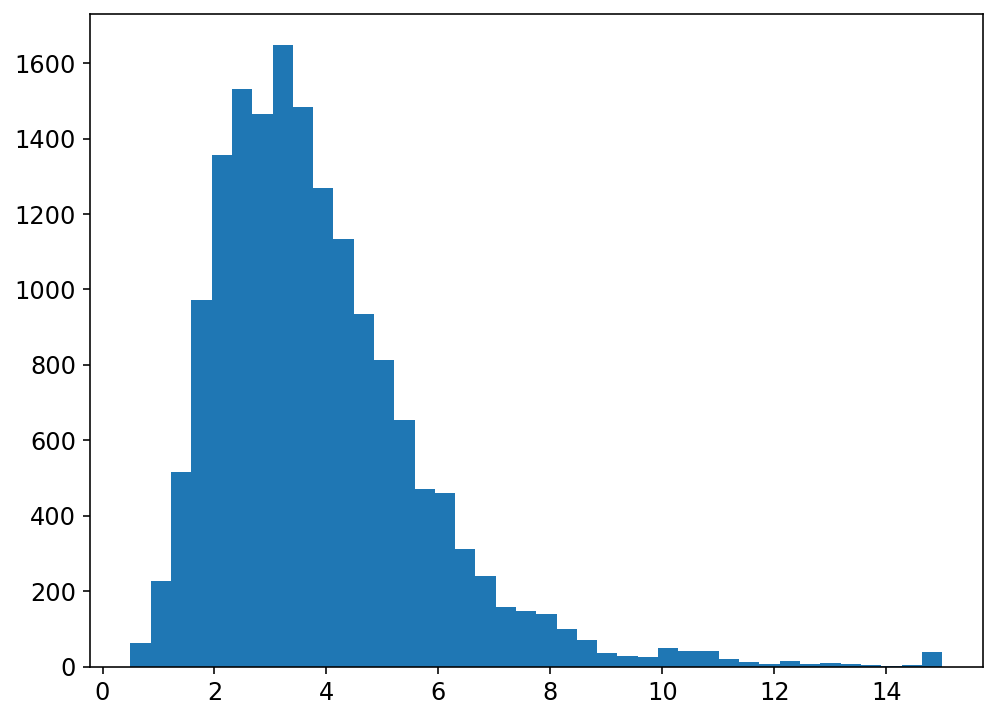

In [9]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# we plot the histogram of the medium income feature
# to see what's a reasonable range for the data
plt.hist(X_train[:, 0], bins=40)
plt.show()

In [10]:
impute_values = np.arange(1, 11)

# https://stackoverflow.com/questions/1550130/cloning-row-or-column-vectors
row = X_train[0]
rows = np.repeat(row[np.newaxis, :], impute_values.shape[0], axis=0)
rows[:, 0] = impute_values

In [11]:
drows = xgb.DMatrix(rows, feature_names=cal_housing.feature_names)
predictions = model_no_constraint.predict(drows)
predictions

array([1.0887971, 1.3267556, 1.4421465, 1.7214452, 1.9341432, 2.3026903,
       3.1227002, 3.1882827, 2.9910197, 2.8958788], dtype=float32)

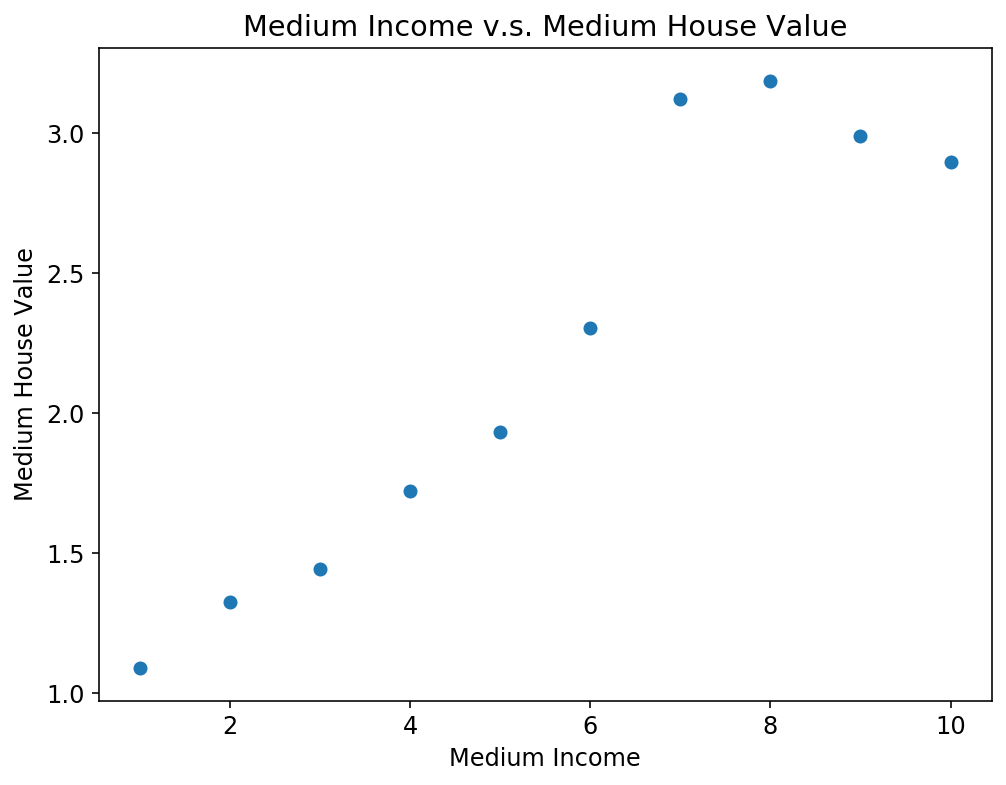

In [12]:
plt.scatter(impute_values, predictions)
plt.title('Medium Income v.s. Medium House Value')
plt.xlabel('Medium Income')
plt.ylabel('Medium House Value')
plt.show()

From the scatter plot above, we can see that the relationship between median income and median house value is not strictly monotonic. If we find that it is hard to justify that neighborhoods with a low medium income will have a higher median house value, we can enforce the monotonicity on the median income feature. 

## XGBoost Monotonic Constraint

The way to enforce [monotonicity constraint in XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html) is by passing the `monotone_constraints` parameter.

In [13]:
monotone_constraints = ['1' if col == 'MedInc' else '0' for col in cal_housing.feature_names]
monotone_constraints = '(' + ','.join(monotone_constraints) + ')'
monotone_constraints

'(1,0,0,0,0,0,0,0)'

It will be a tuple-like string where 1 indicates an increasing constraint, 0 indicates no constraint and -1 indicates a decreasing constraint. The ordering of the number matches the ordering of our feature in the dataset. In our case, medium income is the first feature in our dataset, hence we indicate we want it to have an increasing constraint (higher the medium income, the higher the medium house value) by passing a 1 in the first number.

> LightGBM has the exact same parameter, except we should pass the constraint as a list of values instead of a tuple-like string

In [14]:
params_constraint = deepcopy(params_no_constraint)
params_constraint['monotone_constraints'] = monotone_constraints

In [15]:
evals_result = {}
model_constraint = xgb.train(
    params_constraint, dtrain,
    evals=evals,
    evals_result=evals_result,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=50)

[0]	train-rmse:1.78659	eval-rmse:1.7838
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[50]	train-rmse:0.479643	eval-rmse:0.500736
[100]	train-rmse:0.437175	eval-rmse:0.480962
[150]	train-rmse:0.413551	eval-rmse:0.474574
[200]	train-rmse:0.391998	eval-rmse:0.46953
Stopping. Best iteration:
[229]	train-rmse:0.381613	eval-rmse:0.466634



In [16]:
# we also double-check the model performance
r2, rmse, mape = compute_score(model_constraint, dtest)

r2:  0.836
rmse:  0.467
mape:  0.177


In [17]:
drows = xgb.DMatrix(rows, feature_names=cal_housing.feature_names)
predictions = model_constraint.predict(drows)
predictions

array([1.041534 , 1.0967472, 1.3294389, 1.6993836, 2.0748453, 2.6741812,
       3.5940247, 3.7912014, 4.1798806, 4.1798806], dtype=float32)

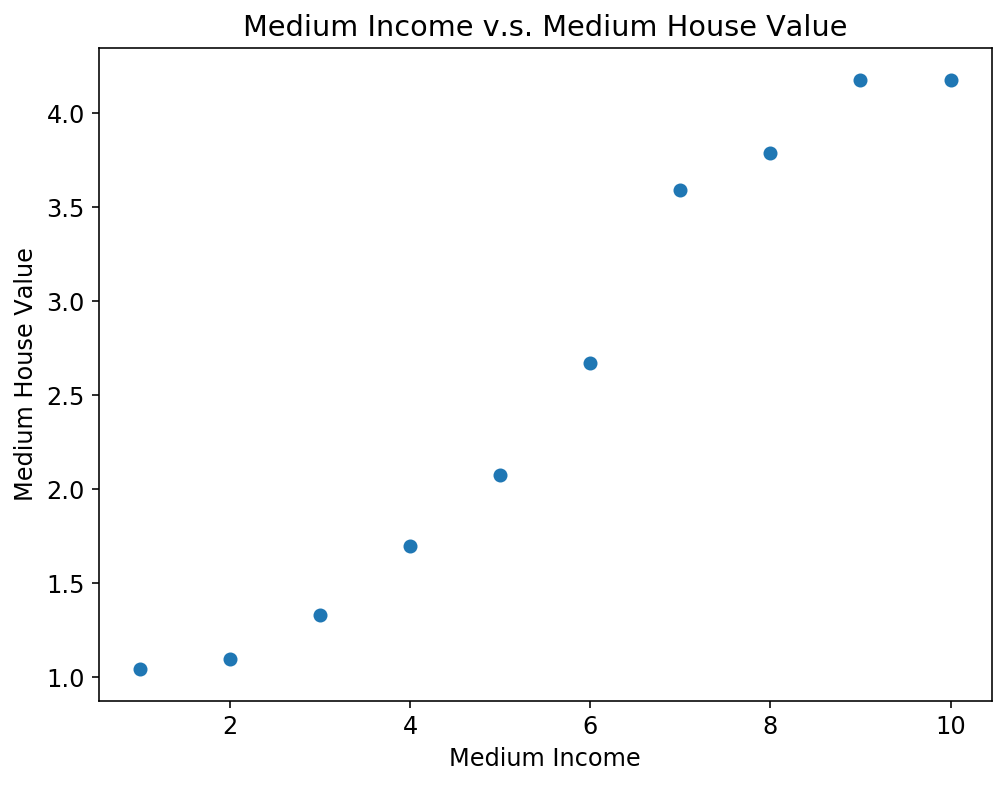

In [18]:
plt.scatter(impute_values, predictions)
plt.title('Medium Income v.s. Medium House Value')
plt.xlabel('Medium Income')
plt.ylabel('Medium House Value')
plt.show()

After applying the monotonic constraint parameter, the response is now monotonically increasing with the predictor.

So was it a good idea to enforce monotonicity constraints on features? it depends. For the example here:

- Performance-wise: We didn't see a significant performance decrease on the test set after applying the constraint.
- Interpretation-wise: It is up to our domain knowledge and see whether enforcing monotonic relationship makes intuitive sense.

One can view monotonic constraint a type of regularization and it is upon us, the end user, to fit a model that is as simple as possible, but no simpler.

## XGBoost Monotonic Constraint Implementation Details

When growing a tree within the boosted tree, the algorithm will abandon a candidate split if it causes non-monotonic relationship. Imagine we specify a positive monotonic constraint on a particular feature $f$. Then when $f$ gets picked and a split at value $v$ will result in the best gain. We will check whether the weight assigned to the right child is greater than the left child. If this is the case, then it will proceed with performing the split at value $v$, if not it will give up splitting on value $v$ and trying to find the next best split, until the weight of the right child is higher than that of the left child.

If we look at the [XGBoost code snippet](https://github.com/dmlc/xgboost/blob/97abcc7ee2a67194916fb1be17e55a29ca11ea57/src/tree/constraints.cuh), we can see that if the positive monotonic condition is specified `if constraint > 0`, then we check the weight of the right child versus left `wleft <= wright`, if the constraint is met, then the gain is retained `? gain`, else the gain is replaced by negative infinity `? negative_infinity`.

<img src="img/monotonic_node.png" width="60%" height="60%">

Now this sounds good when the feature is picked once, however, what if on a split further down the tree that feature gets picked again? Let's imagine if the tree goes on and do the same thing to the left child (L) which happens to pick the same feature again, we will get a higher weight assigned to the right child of the left child (LR) because of the positive monotonic constraint we enforced. That weight, however, may be even higher than that of the right child (R) we previously obtained. In other words, we need to have make sure the constraint is enforced at the tree level. Not only should the weight assigned to the right child (R) be higher than the left child (L), but it should also be higher than its descendant that decides to use the same feature (LL, LR, LLL, LLR, LRL, LRR, etc.)

To achieve this, when splitting on a node, the weight of the children node is bounded by the mean of their parent and uncle nodes weight (uncle refers to the same level as the node's direct parent).

Using a similar example stated above: the weight of the left child's right child (LR) is now bounded by the left child(L) and right child(R)'s mean weight. And because the weight of the left child(L) is lower than the right child(R), the weight of the left child's right child (LR) can never exceed the weight of the right child(R).


<img src="img/monotonic_tree.png" width="60%" height="60%">

Or if preferred the psuedocode below:

```python
min_value = node.min_value
max_value = node.max_value

check(min_value <= split.left_output) 
check(min_value <= split.right_output)
check(max_value >= split.left_otput)
check(max_value >= split.right_output)
mid = (split.left_output + split.right_output) / 2;

if (split.feature is monotonic increasing) {
  check(split.left_output <= split.right_output)
  node.left_child.set_max_value(mid)
  node.right_child.set_min_value(mid)
}
if (split.feature is monotonic decreasing ) {
  check(split.left_output >= split.right_output)
  node.left_child.set_min_value(mid)
  node.right_child.set_max_value(mid)
}
```

## LightGBM Monotonic Constraint

Specifying monotonic constraint is also available in lightgbm, expect the parameters are a little different from xgboost.

In [19]:
dtrain = lgb.Dataset(X_train, y_train,
                     feature_name=cal_housing.feature_names,
                     free_raw_data=False)
dtest = lgb.Dataset(X_test, y_test,
                    feature_name=cal_housing.feature_names,
                    free_raw_data=False)
dtrain

To specify the monotonic constraint, we use a list of integers instead of a tuple like string.

In [20]:
monotone_constraints = [1 if col == 'MedInc' else 0 for col in cal_housing.feature_names]

params_constraint = {
    'nthread': 6,
    'seed': 0,
    'metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'monotone_constraints': monotone_constraints
}
 
evals_result = {}
model_constraint = lgb.train(
    params_constraint, dtrain,
    valid_sets=[dtrain, dtest],
    evals_result=evals_result,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=50)

Training until validation scores don't improve for 10 rounds.
[50]	training's rmse: 0.488685	valid_1's rmse: 0.503612
[100]	training's rmse: 0.444494	valid_1's rmse: 0.48004
[150]	training's rmse: 0.422314	valid_1's rmse: 0.473423
[200]	training's rmse: 0.405314	valid_1's rmse: 0.470076
Early stopping, best iteration is:
[216]	training's rmse: 0.40057	valid_1's rmse: 0.469415


In [21]:
impute_values = np.arange(1, 11)

# https://stackoverflow.com/questions/1550130/cloning-row-or-column-vectors
row = X_train[0]
rows = np.repeat(row[np.newaxis, :], impute_values.shape[0], axis=0)
rows[:, 0] = impute_values

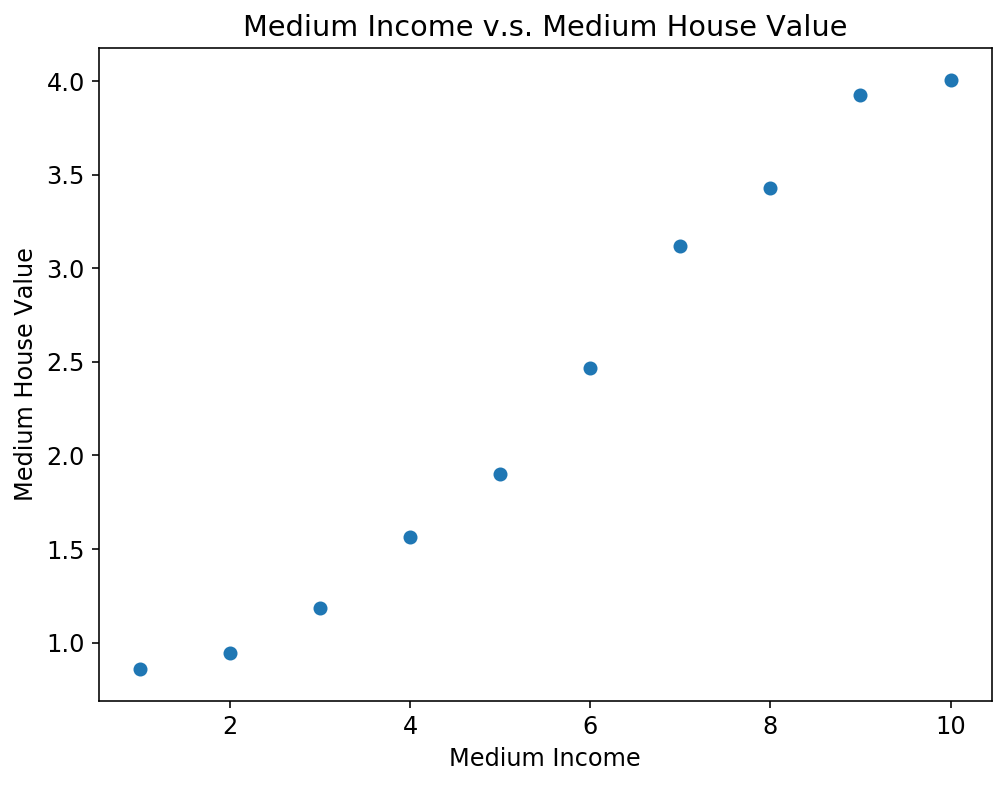

In [22]:
predictions = model_constraint.predict(rows)

plt.scatter(impute_values, predictions)
plt.title('Medium Income v.s. Medium House Value')
plt.xlabel('Medium Income')
plt.ylabel('Medium House Value')
plt.show()

# Reference

- [Blog: Monotonicity constraints in machine learning](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
- [Blog: A Tutorial of Model Monotonicity Constraint Using Xgboost](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
- [Blog: How does the popular XGBoost and LightGBM algorithm enforce monotonic constraint](https://towardsdatascience.com/how-does-the-popular-xgboost-and-lightgbm-algorithms-enforce-monotonic-constraint-cf8fce797acb)
- [Stackoverflow: how does xgboost enforce monotonicity constraints](https://stackoverflow.com/questions/44236078/how-does-xgboost-enforce-monotonicity-constraints)